## 1. Resolve K, R, t and K', R', t' from P and P'

In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
DIST_NUM = 45
mLambda = 10

In [2]:
P = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])
Pp = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9998813487,0.0148994942,0.0039106989],
               [-0.0148907594,0.9998865876,-0.0022532664],
               [-0.0039438279,0.0021947658,0.9999898146],
               [-9.9909793759,0.2451742154,0.1650832670]])
print(P, Pp)

[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]] [[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
 [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.99881349e-01  1.48994942e-02  3.91069890e-03]
 [-1.48907594e-02  9.99886588e-01 -2.25326640e-03]
 [-3.94382790e-03  2.19476580e-03  9.99989815e-01]
 [-9.99097938e+00  2.45174215e-01  1.65083267e-01]]


## 2. Find X' from the Camera Matrices, and Do Graph Cut

Disparity is the times of et, thus, Disparities might need to be float for accuracy.

# generate a number of disparities as labels
def setDisparities(imgWidth, nDist):
    # Dist might need to be float
    distStep = int(imgWidth/nDist)
    dists = np.array(range(0, imgWidth, distStep))
    for eachDist in dists:
        if(eachDist!=0):
            eachDist-=1
    return dists

In [3]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    if distStep < 1:
        dists = np.array(range(0, int(maxDist*10000), int(distStep*10000)))
        dists = dists/10000
    else:   
        dists = np.array(range(0, maxDist, distStep))
    return dists

In [4]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))
        

In [5]:
def buildGraphFromImages(img1, img2, dists, P, Pp):
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)    
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = P[0:3,:], P[3:6, :], P[6, :]
    Kp, Rp, Tp = Pp[0:3,:], Pp[3:6, :], Pp[6, :]
#     print(K, R, T)
#     print(Kp, Rp, Tp)
    mat2 = Kp.dot(np.transpose(Rp))
    mat1 = mat2.dot(R).dot(np.linalg.inv(K))
    mat3 = mat2.dot((T-Tp))
#     positionMat = np.zeros((3, nNodes))
#     for r in range(0, imgHeight):
#         for c in range(0, imgWidth):
#             xMat[:, r*imgWidth+c] = np.array([r, c, 1])
#     xpMat = mat1.dot(xMat)+mat3.dot(dists)
    
    #     print(Kp, Rp, Tp)
    # initialize prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
            pairwiseCost[i][j] = abs(dists[i]-dists[j])
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(255)
#     print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            if(rightNodeNo < nNodes and c < imgWidth-1):
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo])
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeIndex+=1
            # unary cost /= data term:
            x = np.array([r, c, 1])
            xInfinite = mat1.dot(x)
            if(xInfinite[2] != 0):
                xInfinite = xInfinite/xInfinite[2]
            for i in range(0, nDists):
                dist = dists[i]
                # make inhomogeneous coordinate of x:
                ep = dist*mat3
                xp = xInfinite + ep
                # normalize x'
                xp = xp/xp[2]
                if (xp[0] < imgHeight and xp[0] >= 0 and xp[1] < imgWidth and xp[1] >= 0):
                    leftNodeRGB = img1[r, c]
                    rightNodeRGB = img2[int(xp[0]), int(xp[1])]
                    unaryCosts[nodeNo,i] = getRgbDist(leftNodeRGB, rightNodeRGB)
        
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [6]:
# form an image from lables:
def formImg(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
            output[r][c] = label*grayScaleStep
    return output

In [7]:
leftImg = cv2.imread('test00.jpg')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('test09.jpg')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)

In [8]:
MAX_DIST = 0.004
DIST_STEP = 0.0001

In [9]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009
 0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039]


In [10]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

6.375


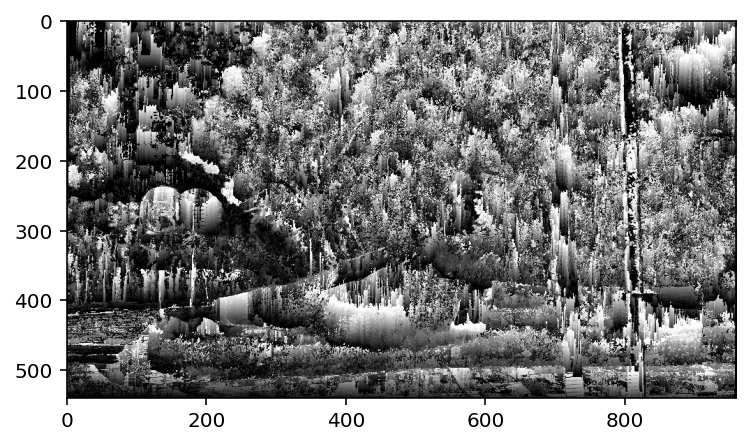

[0 0 0 ... 0 0 0]


In [11]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), (pairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

1.275


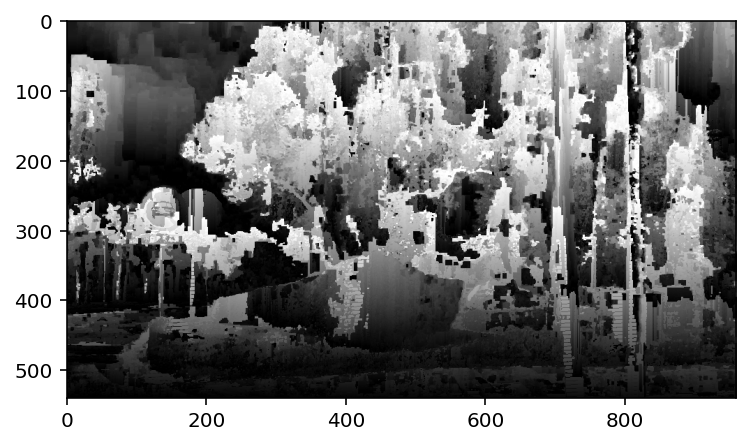

[19 19 19 ... 12 12 12]


In [15]:
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), 1000*(pairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

In [12]:
MAX_DIST = 0.02
DIST_STEP = 0.0001

dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009
 0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005  0.0051 0.0052 0.0053 0.0054 0.0055 0.0056 0.0057 0.0058 0.0059
 0.006  0.0061 0.0062 0.0063 0.0064 0.0065 0.0066 0.0067 0.0068 0.0069
 0.007  0.0071 0.0072 0.0073 0.0074 0.0075 0.0076 0.0077 0.0078 0.0079
 0.008  0.0081 0.0082 0.0083 0.0084 0.0085 0.0086 0.0087 0.0088 0.0089
 0.009  0.0091 0.0092 0.0093 0.0094 0.0095 0.0096 0.0097 0.0098 0.0099
 0.01   0.0101 0.0102 0.0103 0.0104 0.0105 0.0106 0.0107 0.0108 0.0109
 0.011  0.0111 0.0112 0.0113 0.0114 0.0115 0.0116 0.0117 0.0118 0.0119
 0.012  0.0121 0.0122 0.0123 0.0124 0.0125 0.0126 0.0127 0.0128 0.0129
 0.013  0.0131 0.0132 0.0133 0.0134 0.0135 0.0136 0.0137 0.0138 0.0139
 0.014

1.275


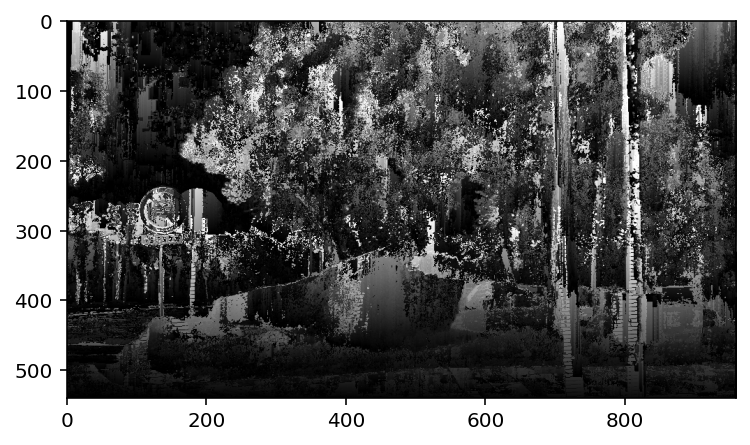

[0 0 0 ... 0 0 0]


In [13]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), (pairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

1.275


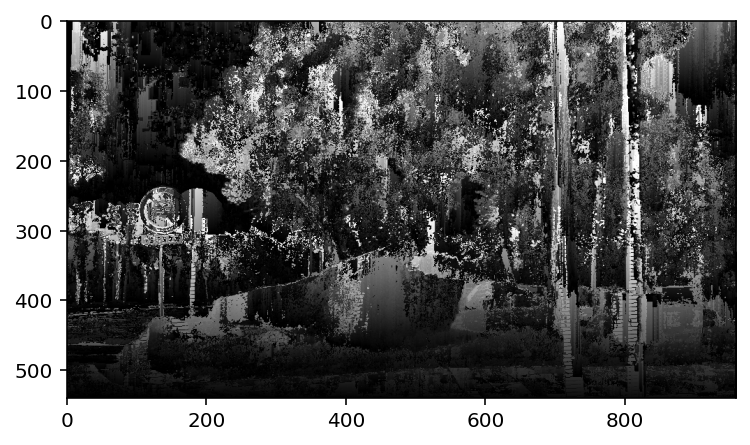

[0 0 0 ... 0 0 0]


In [14]:
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), (pairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)